# Training Technology

## Import Library

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import copy
import torch
# from PIL import Image
# import pickle
import import_ipynb
sys.path.append(os.pardir)
from DataSet.mnist import load_mnist
from Ch2_3.handWrittenDigit import get_data, init_network, predict, img_show
from Ch2_3.activation_function import softmax, sigmoid
from Ch4.load_error import cross_entropy_error
from Ch5.layer_naive import TwoLayerNet

## 확률적 경사 하강법 ( SGD, Stochastic Gradient Descent )

### $\mathrm{W}\leftarrow\mathrm{W}-\eta{\partial L\over\partial\mathrm{W}}$

In [4]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
	
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## SGD의 단점

### $f(x,y)={1\over20}x^2+y^2$

In [5]:
def function_1(x,y):
    return x**2/20 + y**2

In [6]:
def gradient_function_1(params):
    grad={}
    grad['x'] = params['x']/10
    grad['y'] = params['y']*2
    
    return grad

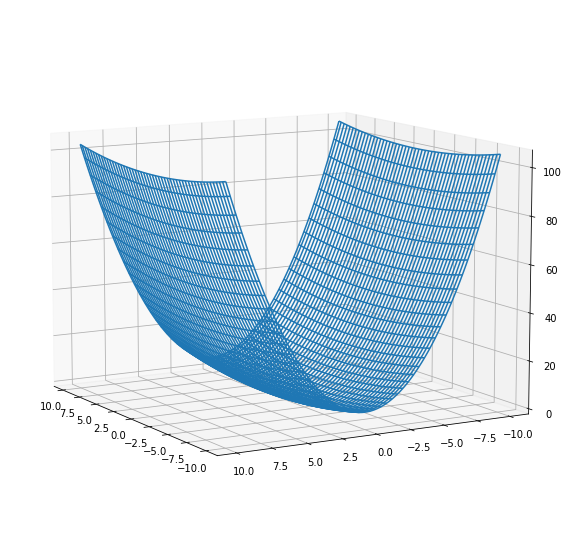

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

X = np.arange(-10,10,0.1)
Y = np.arange(-10,10,0.1)
X,Y = np.meshgrid(X,Y)
Z = function_1(X,Y)

ax.plot_wireframe(X,Y,Z)
ax.view_init(10,150) # vertical, horizontal
plt.show()


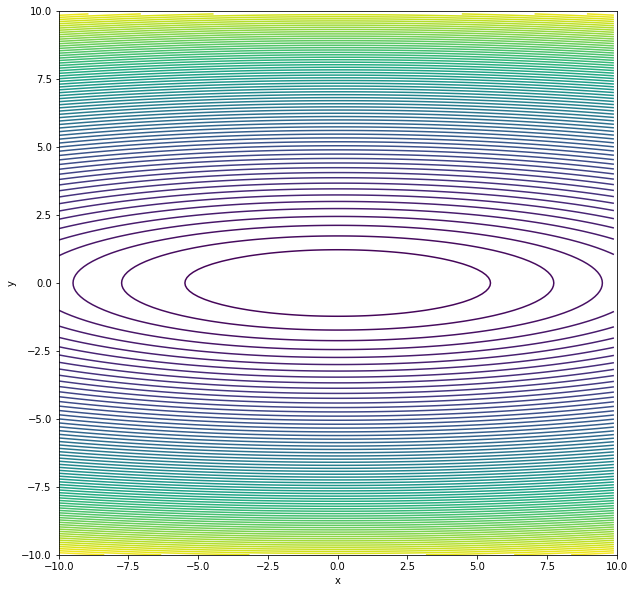

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(X,Y,Z,levels=90)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
a = np.zeros((2,400))
print(a.shape)

(2, 400)


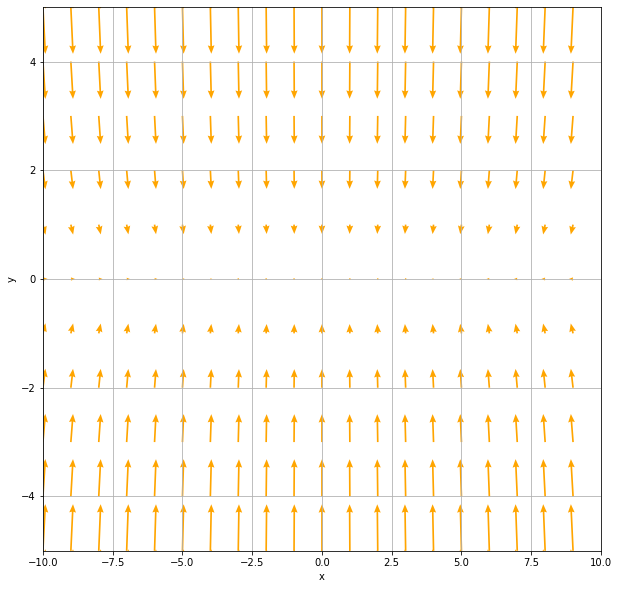

In [10]:
X = np.arange(-10,10,1)
Y = np.arange(-10,10,1)
X,Y = np.meshgrid(X,Y)
X = X.flatten()
Y = Y.flatten()

grad = np.zeros((2,400))
grad[0] = X/10
grad[1] = Y*2

plt.figure(figsize=(10,10))
plt.quiver(X,Y,-grad[0],-grad[1], angles='xy', headwidth=4,scale=120,color="orange")
plt.xlim(-10,10)
plt.ylim(-5,5)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [11]:
iter_num = 30
sgd = SGD(0.9)
grad = {}
params = {}
params['x'] = -7.0
params['y'] = 2.0

sgd_optimization_X = [params['x']]
sgd_optimization_Y = [params['y']]

for i in range(1,iter_num):
    # get grad
    grad = gradient_function_1(params)
    
    # update parameters
    sgd.update(params,grad)
    
    # save history
    sgd_optimization_X.append(params['x'])
    sgd_optimization_Y.append(params['y'])
    
    

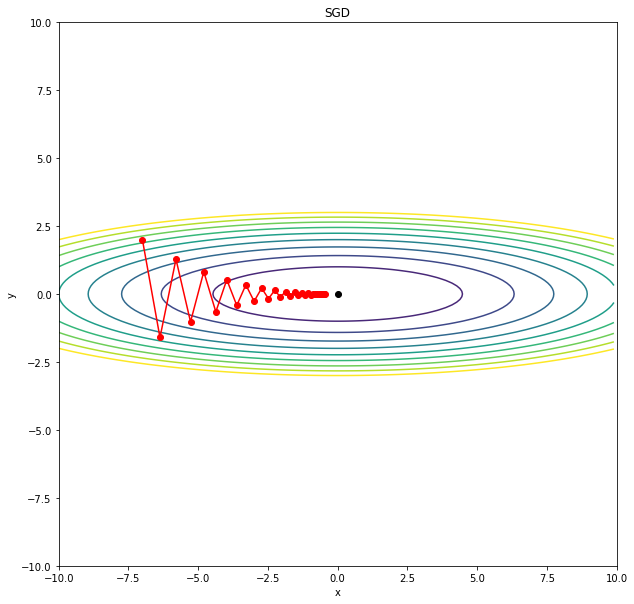

In [12]:
X = np.arange(-10,10,0.1)
Y = np.arange(-10,10,0.1)
X,Y = np.meshgrid(X,Y)
Z = function_1(X,Y)
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(X,Y,Z,levels=np.arange(0,10,1))
ax.plot(sgd_optimization_X,sgd_optimization_Y,'-or')
ax.plot(0,0,'o',color='black')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('SGD')
plt.show()

## Momentum

### $\mathbf{v}\leftarrow\alpha\mathbf{v}-\eta{\partial L\over\partial\mathbf{W}}\\\mathbf{W}\leftarrow\mathbf{W}+\mathbf{v}$

In [13]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [14]:
iter_num = 30
momentum = Momentum(lr=0.1)
grad = {}
params = {}
params['x'] = -7.0
params['y'] = 2.0

momentum_optimization_X = [params['x']]
momentum_optimization_Y = [params['y']]

for i in range(1,iter_num):
    # get grad
    grad = gradient_function_1(params)
    
    # update parameters
    momentum.update(params,grad)
    
    # save history
    momentum_optimization_X.append(params['x'])
    momentum_optimization_Y.append(params['y'])
    
    

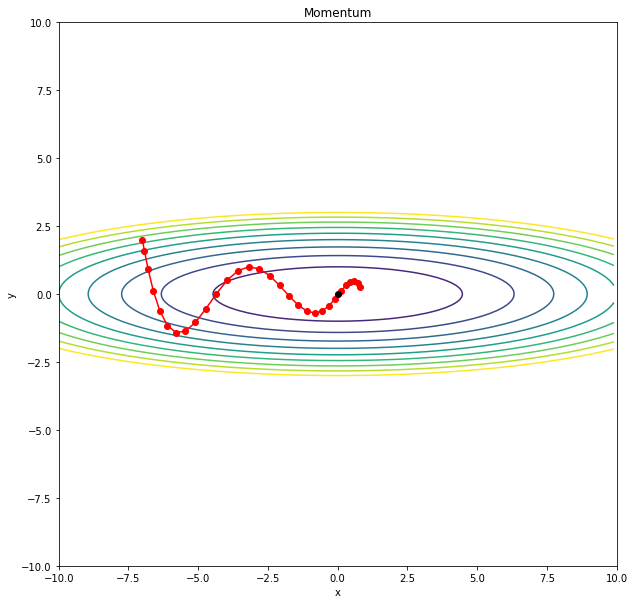

In [15]:
X = np.arange(-10,10,0.1)
Y = np.arange(-10,10,0.1)
X,Y = np.meshgrid(X,Y)
Z = function_1(X,Y)
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(X,Y,Z,levels=np.arange(0,10,1))
ax.plot(momentum_optimization_X,momentum_optimization_Y,'-or')
ax.plot(0,0,'o',color='black')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum')
plt.show()

## AdaGrad

### $\mathbf{h}\leftarrow\mathbf{h}+{\partial L\over\partial\mathbf{W}}\odot{\partial L\over\partial\mathbf{W}}\\\mathbf{W}\leftarrow\mathbf{W}-\eta{1\over\sqrt\mathbf{h}}{\partial L\over\partial\mathbf{W}}$

In [16]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr*grads[key] / (np.sqrt(self.h[key])+1e-7)

In [17]:
iter_num = 30
adagrad = AdaGrad(lr=1.4)
grad = {}
params = {}
params['x'] = -7.0
params['y'] = 2.0

adagrad_optimization_X = [params['x']]
adagrad_optimization_Y = [params['y']]

for i in range(1,iter_num):
    # get grad
    grad = gradient_function_1(params)
    
    # update parameters
    adagrad.update(params,grad)
    
    # save history
    adagrad_optimization_X.append(params['x'])
    adagrad_optimization_Y.append(params['y'])
    
    

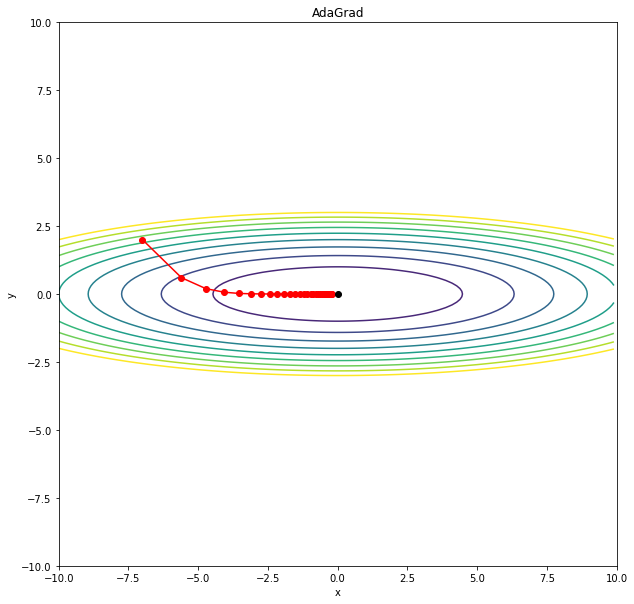

In [18]:
X = np.arange(-10,10,0.1)
Y = np.arange(-10,10,0.1)
X,Y = np.meshgrid(X,Y)
Z = function_1(X,Y)
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(X,Y,Z,levels=np.arange(0,10,1))
ax.plot(adagrad_optimization_X,adagrad_optimization_Y,'-or')
ax.plot(0,0,'o',color='black')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('AdaGrad')
plt.show()

## Adam

### $\mathbf{m}\leftarrow\beta_1\mathbf{m}+(1-\beta_1){\partial L\over\partial\mathbf{W}}\\\mathbf{v}\leftarrow\beta_2\mathbf{v}+(1-\beta_2){\partial L\over\partial\mathbf{W}}\odot{\partial L\over\partial\mathbf{W}}\\\mathbf{W}\leftarrow\mathbf{W}-\mathbf{m}{\eta\over\sqrt{\mathbf{v}+\epsilon}}$

In [19]:
class Adam:
    def __init__(self, lr = 0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v =None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
            
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t* self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [20]:
iter_num = 30
adam = Adam(lr=0.3)
grad = {}
params = {}
params['x'] = -7.0
params['y'] = 2.0

adam_optimization_X = [params['x']]
adam_optimization_Y = [params['y']]

for i in range(1,iter_num):
    # get grad
    grad = gradient_function_1(params)
    
    # update parameters
    adam.update(params,grad)
    
    # save history
    adam_optimization_X.append(params['x'])
    adam_optimization_Y.append(params['y'])
    
    

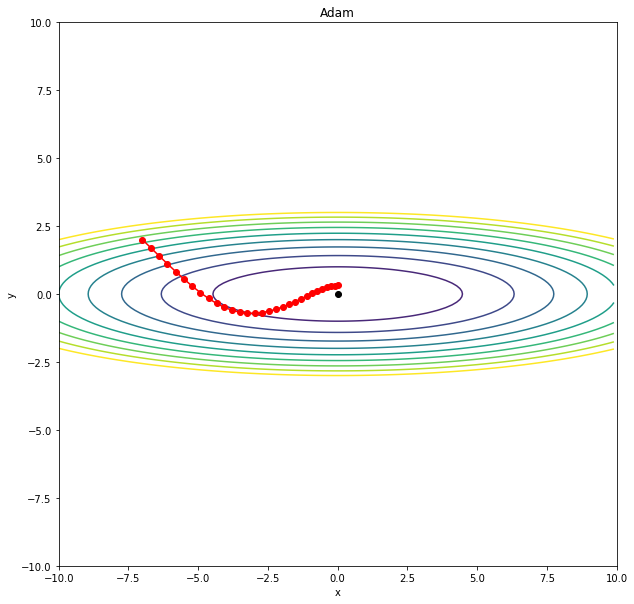

In [21]:
X = np.arange(-10,10,0.1)
Y = np.arange(-10,10,0.1)
X,Y = np.meshgrid(X,Y)
Z = function_1(X,Y)
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(X,Y,Z,levels=np.arange(0,10,1))
ax.plot(adam_optimization_X,adam_optimization_Y,'-or')
ax.plot(0,0,'o',color='black')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adam')
plt.show()

In [61]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True,one_hot_label=True)

In [62]:
# optimizer
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
    train_loss[key] = []

# hyper parameter
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 128
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params,grads)
        loss = networks[key].loss(x_batch,t_batch)
        train_loss[key].append(loss)
    
    if i % 500 == 0:
        print("========="+"iteration"+"=========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch,t_batch)
            print(key + ":" + str(loss))

=========iteration=========
SGD:2.3027120448839735
Momentum:2.303205221269825
AdaGrad:2.2249625085664535
Adam:2.295932460946953
=========iteration=========
SGD:2.149648236273294
Momentum:0.3107212291638759
AdaGrad:0.2776737843152206
Adam:0.25103830728965715
=========iteration=========
SGD:1.074131633399305
Momentum:0.22058692863835083
AdaGrad:0.200127124196582
Adam:0.10363616302489786
=========iteration=========
SGD:0.7150131242799401
Momentum:0.26123840836452866
AdaGrad:0.27498835564066265
Adam:0.21918706776812968


In [63]:
def smooth_curve(x):
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

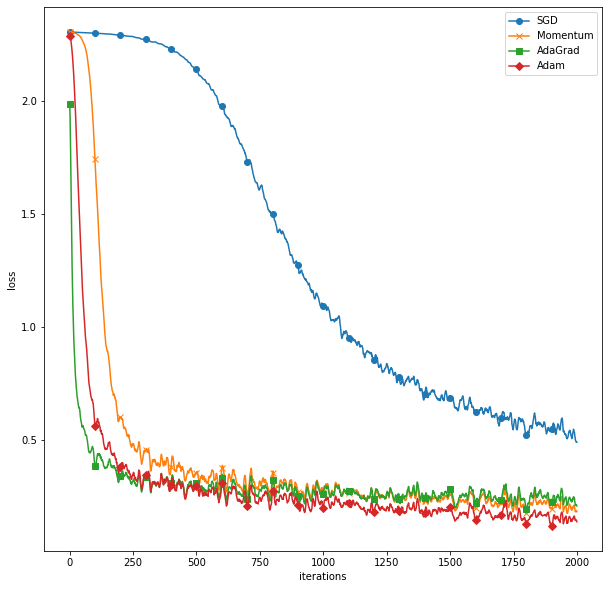

In [64]:
markers = {"SGD":"o","Momentum":"x","AdaGrad":"s","Adam":"D"}
x = np.arange(iters_num)
plt.figure(figsize=(10,10))
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key],markevery=100, label=key)
plt.xlabel('iterations')
plt.ylabel('loss')
# plt.ylim(0,1)
plt.legend()
plt.show()
    